In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

In [177]:
# 데이터 불러오기 및 날짜 처리(object->datatime) 및 정렬
df = pd.read_csv("KOSPI.csv")
df['date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('date')

In [179]:
# 타겟(Event): 5일 수익률 -3% 이하 여부
df['5days_return'] = df['KOSPI_index'].pct_change(periods=5)
df['Event'] = (df['5days_return'] <= -0.03).astype(int)

# EDA 기반 로그변환
df['Volume'] = np.log1p(df['Volume'])
df['Transaction_Amount'] = np.log1p(df['Transaction_Amount'])
df['Credit_Balance_KOSPI'] = np.log1p(df['Credit_Balance_KOSPI'])

# EDA 기반 표준화
scaler1= StandardScaler()
cols_to_scale = ['Volume', 'Transaction_Amount', 'Market_Cap', 'Credit_Balance_KOSPI','Credit_Ratio_to_MarketCap','5days_return']
df_scaled=pd.DataFrame(scaler1.fit_transform(df[cols_to_scale]), columns = cols_to_scale)

scaler2 = RobustScaler()
df_scaled['Credit_Change_Ratio_to_Transaction'] = scaler2.fit_transform(
    df['Credit_Change_Ratio_to_Transaction'].values.reshape(-1, 1)
)
df_scaled['Credit_Change_Ratio_to_Transaction'] = df_scaled['Credit_Change_Ratio_to_Transaction'].clip(-5, 5)

In [181]:
# Flow: 융자 변화량 / 거래대금 (3일 전까지)
flow_lags = list(range(0, 4))  # [0, 1, 2, 3]

# Intens: 융자 잔액 / 시가총액 (20일 전까지)
intens_lags = list(range(0, 21))  # [0, 1, ..., 20]

# Flow lag 변수 생성
for lag in flow_lags:
    df[f'Flow_lag_{lag}'] = df['Credit_Change_Ratio_to_Transaction'].shift(lag)

# Intens lag 변수 생성
for lag in intens_lags:
    df[f'Intens_lag_{lag}'] = df['Credit_Ratio_to_MarketCap'].shift(lag)

# lag 이후 생기는 결측치 제거
df = df.dropna()

In [183]:
# 통계적 트리밍 (AUC기반 lag선별)
X_lag = df[[f'Flow_lag_{l}' for l in flow_lags] + [f'Intens_lag_{l}' for l in intens_lags]]
y = df.loc[X_lag.index, 'Event']

def auc_trim(X, y, threshold=0.01):
    retained = []
    base = roc_auc_score(y, np.full_like(y, y.mean()))  # 베이스라인 AUC (Event 비율 예측)

    for col in X.columns:
        temp_X = X[retained + [col]]
        model = LogisticRegression(penalty=None, max_iter=2000)
        auc = np.mean(cross_val_score(model, temp_X, y, cv=5, scoring='roc_auc'))

        if auc - base > threshold:
            retained.append(col)
            base = auc  # 기여도 반영

    return retained

selected_cols = auc_trim(X_lag, y)
X_trimmed = X[selected_cols]

# 살아남은 lag와 독립변수 통합
base_vars = ['Volume','Transaction_Amount','Market_Cap','Credit_Balance_KOSPI','Credit_Ratio_to_MarketCap','Credit_Change_Ratio_to_Transaction']
X = df[base_vars + selected_cols]
y = df.loc[X.index, 'Event']

In [185]:
# AUC 기준 통과한 lag 변수 확인
auc_flow = [col for col in selected_cols if 'Flow' in col]
auc_intens = [col for col in selected_cols if 'Intens' in col]

print("✅ [AUC 기준 통과] Flow 변수:")
for col in auc_flow:
    print(f" - {col}")

print("\n✅ [AUC 기준 통과] Intens 변수:")
for col in auc_intens:
    print(f" - {col}")

✅ [AUC 기준 통과] Flow 변수:
 - Flow_lag_0

✅ [AUC 기준 통과] Intens 변수:
 - Intens_lag_0
 - Intens_lag_2
 - Intens_lag_3
 - Intens_lag_4
 - Intens_lag_5


In [189]:
# EPV 확인
n_vars = len(X.columns)
n_events = y.sum()
epv = n_events / n_vars if n_vars > 0 else np.nan

print(f"🔍 EPV (Events Per Variable): {epv:.2f}")
print(f"   - 이벤트 수: {int(n_events)}")
print(f"   - 변수 수  : {n_vars}")

# EPV ≥ 10 적용 -- VIF기준 적용 전 EPV 이미 >=10 이므로 필요 X

🔍 EPV (Events Per Variable): 26.00
   - 이벤트 수: 312
   - 변수 수  : 12


In [191]:
# # VIF 기준 다중공선성 변수 제거
def drop_high_vif(X, threshold=10.0):
    while True:
        vifs = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
        if vifs.max() >= threshold:
            X = X.drop(vifs.idxmax(), axis=1)
        else:
            break
    return X

X_final = drop_high_vif(X)
y_final = y.loc[X_final.index]

In [195]:
print("📌 최종 독립변수 목록:")
for col in X_final.columns:
    print(f" - {col}")

📌 최종 독립변수 목록:
 - Volume
 - Flow_lag_0


In [197]:
# 시계열 기반 데이터셋 분할
X_final['date'] = df['date']
y.index = X_final.index

X_train = X_final[X_final['date'] < '2019'].drop(columns='date')
X_val = X_final[(X_final['date'] >= '2019') & (X_final['date'] < '2022')].drop(columns='date')
X_test = X_final[X_final['date'] >= '2022'].drop(columns='date')

y_train = y.loc[X_train.index]
y_val = y.loc[X_val.index]
y_test = y.loc[X_test.index]

In [199]:
# 모델 학습 및 AUC
models = {
    'Logistic': LogisticRegression(penalty=None, solver='lbfgs', max_iter=2000),
    'Lasso': LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000),
    'Ridge': LogisticRegression(penalty='l2', max_iter=2000)
}

# 모델별 Validation/Test set에서의 AUC 평가
for name, model in models.items():
    model.fit(X_train, y_train)

    # Validation set
    val_probs = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)

    # Test set
    test_probs = model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_probs)

    print(f"📊 {name} 모델")
    print(f"   - Validation AUC: {val_auc:.4f}")
    print(f"   - Test AUC      : {test_auc:.4f}\n")

📊 Logistic 모델
   - Validation AUC: 0.6888
   - Test AUC      : 0.7044

📊 Lasso 모델
   - Validation AUC: 0.6775
   - Test AUC      : 0.7071

📊 Ridge 모델
   - Validation AUC: 0.6938
   - Test AUC      : 0.7084



     Variable  Coefficient
0      Volume     0.524591
1  Flow_lag_0     0.128490


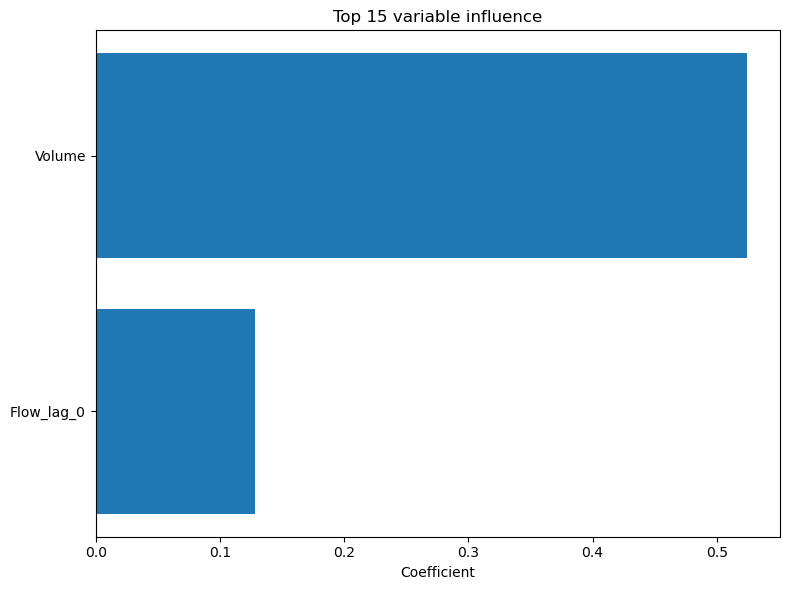

In [205]:
# 변수별 영향력 확인
importance_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coefficient': model.coef_[0]
})

importance_df['AbsCoef'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values('AbsCoef', ascending=False)
print(importance_df[['Variable', 'Coefficient']].head(10))  # Top 10

# 변수별 영향력 시각화
top_k = 15
top_vars = importance_df.head(top_k)

plt.figure(figsize=(8, top_k * 0.4))
plt.barh(top_vars['Variable'][::-1], top_vars['Coefficient'][::-1])
plt.axvline(0, color='gray', linestyle='--')
plt.title(f"Top {top_k} variable influence")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

In [207]:
# 전략 수익률 시뮬레이션(복리 누적수익률 기준) 
final_model = LogisticRegression(penalty='l2', max_iter=2000)
final_model.fit(X_train, y_train)
p_test = final_model.predict_proba(X_test)[:, 1]
returns = df.loc[X_test.index, '5days_return'].values

qs = np.linspace(0, 1, 100)
compound_returns = []

for q in qs:
    s = (p_test > q).astype(int)
    r_strategy = (1 - s) * returns
    compounded = np.prod(1 + r_strategy) - 1
    compound_returns.append(compounded)

best_q = qs[np.argmax(compound_returns)]
print(f"최적 q: {best_q:.4f}")

최적 q: 0.0808


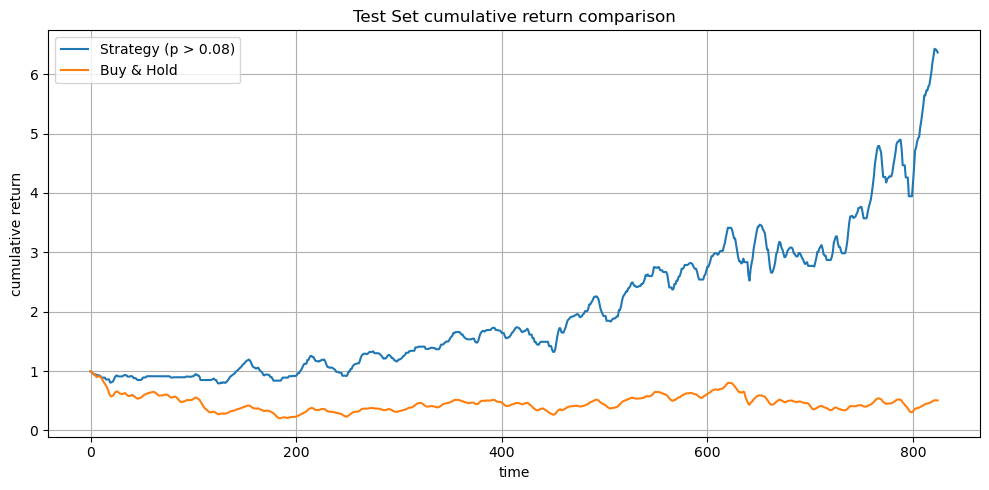

In [209]:
# 누적수익률 시각화
s = (p_test > best_q).astype(int)
strategy_r = (1 - s) * returns
strategy_cum = np.cumprod(1 + strategy_r)
buyhold_cum = np.cumprod(1 + returns)

plt.figure(figsize=(10, 5))
plt.plot(strategy_cum, label=f'Strategy (p > {best_q:.2f})')
plt.plot(buyhold_cum, label='Buy & Hold')
plt.title("Test Set cumulative return comparison")
plt.xlabel("time")
plt.ylabel("cumulative return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()